In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

# 美股

## 2003~2009實驗
- **稅前** OR **稅後** 5000萬或7500萬
- +當年度ROE出場
- 本益比進場條件
- 盈再率單獨調整
- 盈再率+ROE
- 盈再率+配息

## import

In [2]:
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from matplotlib.colors import ListedColormap

from dataframe import CustomDataFrame

import plot_data

In [3]:
# pd.options.display.float_format = '{:.4f}'.format # 禁用科學數字

## 日期設定

In [4]:
START_DATE = '2003-3-31'
END_DATE = '2009-3-31'

## 成分股比較

In [5]:
russell_1000_df = pd.read_csv('./russell_component_lists/russell_1000_company.csv')
russell_2000_df = pd.read_csv('./russell_component_lists/russell_2000_company.csv')
russell_3000_df = pd.read_csv('./russell_component_lists/russell_3000_company.csv')

russell_1000_symbol = russell_1000_df['Symbol'].to_list()
russell_2000_symbol = russell_2000_df['Symbol'].to_list()
russell_3000_symbol = russell_3000_df['Symbol'].to_list()

# Find elements only in russell_1000, or russell_2000, but not in russell_3000
only_russell_1000 = list(set(russell_1000_symbol) - set(russell_3000_symbol))
only_russell_2000 = list(set(russell_2000_symbol) - set(russell_3000_symbol))

print(only_russell_2000)
print(len(only_russell_2000))

# 結論 - 在羅素2000當中的公司不一定會在羅素3000

['QUAD', 'UNTY', 'NNBR', 'QRHC', 'MAMA', 'ZURA', 'LVWR', 'CTNM', 'CBNK', 'HBB', 'KRO', 'NKTR', 'LCTX', 'SGC', 'MLP', 'GEOS', 'QIPT', 'TRVI', 'ORN', 'RMBL', 'AVAH', 'PLBC', 'OPFI', 'OPAD', 'AISP', 'LXEO', 'RGTI', 'WEYS', 'TLYS', 'PVBC', 'NAUT', 'EP', 'BDTX', 'SST', 'LCUT', 'INBK', 'NODK', 'NL', 'VRA', 'ANRO', 'PINE', 'MAPS', 'LCNB', 'REAL', 'PCB', 'TSQ', 'AMTX', 'UP', 'AVBP', 'AKYA', 'WLFC', 'INFU', 'CLPR', 'GRPN', 'FBLG', 'DTI', 'GCTS', 'AQST', 'BWFG', 'MPX', 'INMB', 'BELFA', 'DIBS', 'VIRC', 'PKOH', 'LNZA', 'ADCT', 'CBUS', 'VRCA', 'LEGH', 'GOCO', 'AAOI', 'GCBC', 'QTTB', 'BBCP', 'SKYE', 'ITIC', 'OVLY', 'METCB', 'BBAI', 'FENC', 'SMHI', 'ULBI', 'RDW', 'FSP', 'CDZI', 'QBTS', 'PYXS', 'MDWD', 'ILPT', 'RSVR', 'PROP', 'IBEX', 'HQI', 'RNGR', 'ITI', 'TALK', 'CRML', 'KFS', 'AOMR', 'AILE', 'NPCE', 'AEVA', 'HG', 'JILL', 'PRLD', 'BTMD', 'RDZN', 'FFNW', 'ATOS', 'MFIN', 'SGHT', 'DC', 'HRTG', 'ALCO', 'VLGEA', 'BARK', 'RGLS', 'MKTW', 'BPRN', 'EGAN', 'NWFL', 'HPK', 'URG', 'BYRN', 'BOLD', 'FHTX', 'STRS', 

## get data

In [6]:
data=Data(market='US')

---

---

## 資料下載

In [7]:
close = data.get('price:close')

### **盈餘再投資率**

In [8]:
netIncome = data.get('annual_report_fundamentals:netIncome')

# 4 年加總 #
df = netIncome.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每四年進行加總
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(4, min_periods=4).sum())
# result

# 刪除用來group的欄位
netprofit_rol = result.drop(columns='month')

In [9]:
# 去除稅後淨利為負 (計算盈再率)
adj_netprofit = netprofit_rol[(netprofit_rol > 0) & (netIncome > 0)]

In [10]:
# 長期投資
longTermInvestments = data.get('annual_report_fundamentals:longTermInvestments')
# 固定資產
propertyPlantEquipmentNet = data.get('annual_report_fundamentals:propertyPlantEquipmentNet')


capex = longTermInvestments + propertyPlantEquipmentNet
# 以月份為單位，所以要減掉 48 個月前的資料 (第四年 - 第0年)
capex_rol = capex.diff(48)


rr = capex_rol / adj_netprofit

In [11]:
# plot_data.numeric_bins(rr.resample("A-MAY").last(), '美股盈再率')

---

### **本益比 (P/E)**

In [12]:
pe = data.get('quarter_report:PE')

In [13]:
eps = data.get('quarter_report:EPS')

#### 每日本益比

In [14]:
eps_rol = eps + eps.shift(3) + eps.shift(6) + eps.shift(9) # 近四季加總
pe_daily = (close / eps_rol)
pe_daily = pe_daily[eps_rol > 0]

### **其他因子**

- ROE
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- ~~董監持股~~
- 上市上櫃滿兩年

In [15]:
roe = data.get('annual_report:ROE')

In [16]:
dpr = data.get('annual_report_fundamentals:dividendPayoutRatio')
# dpr

In [17]:
income_bf_tax = data.get('annual_report_fundamentals:incomeBeforeTax')

In [18]:
comp_profile = data.get('company_profile')
comp_profile

,company_symbol,name,ipo_date,industry
0,A,"Agilent Technologies, Inc.",1999-11-18,Medical - Diagnostics & Research
1,AA,Alcoa Corporation,2016-11-01,Aluminum
2,AAL,American Airlines Group Inc.,2005-09-27,"Airlines, Airports & Air Services"
3,AAN,"The Aaron's Company, Inc.",2020-11-25,Rental & Leasing Services
4,AAON,"AAON, Inc.",1992-12-16,Construction
...,...,...,...,...
2634,ZUMZ,Zumiez Inc.,2005-05-06,Apparel - Retail
2635,ZUO,"Zuora, Inc.",2018-04-12,Software - Infrastructure
2636,ZWS,Zurn Elkay Water Solutions Corporation,2012-03-29,Industrial - Pollution & Treatment Controls
2637,ZYME,Zymeworks Inc.,2017-04-28,Biotechnology


In [19]:
stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date = row['ipo_date']
    end_date = listed_date + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed_df = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 40%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [20]:
# ROE 5年平均 > 15%
df = roe.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組，對每個月份的每5年計算平均
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
# 刪除用來group的欄位
roe_rol = result.drop(columns='month')

In [21]:
roe_cond = roe_rol > 0.15

In [22]:
rr_cond = rr < 0.4

In [23]:
netprofit_cond = netIncome > 75000000

In [24]:
bf_tax_cond = income_bf_tax > 75000000

In [25]:
payout_ratio = dpr[(netIncome > 0) & (dpr > 0)]


# 3 年至少 > 40%
df = payout_ratio.copy()
# 提取index的月份
df['month'] = df.index.month
# 依據月份分組
result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(3, min_periods=3).min())
# 刪除用來group的欄位
payout_ratio_rol = result.drop(columns='month')

In [26]:
payout_cond = payout_ratio_rol >= 0.4

In [27]:
pe_cond_entry = pe < 12
pe_cond_exit = pe > 30

In [28]:
daily_pe_entry = (pe_daily.resample('M').last() < 12)[START_DATE:END_DATE]
daily_pe_exit = (pe_daily.resample('M').last() > 30)[START_DATE:END_DATE]

In [29]:
listed_cond = listed_df.resample('M').last()

---

## 單一條件

In [30]:
roe_cond_rep = backtest.sim(roe_cond[START_DATE:END_DATE], resample='M' , data=data)
roe_cond_rep.get_stats()

{'CAGR': 0.07803381090431727,
 'daily_sharpe': 71.41,
 'max_drawdown': -0.5388225214816141,
 'avg_drawdown': -0.06887772642492536,
 'win_ratio': 0.6270096463022508,
 'ytd': -0.08925884328250411}

In [31]:
rr_cond_rep = backtest.sim(rr_cond[START_DATE:END_DATE], resample='M', data=data)
rr_cond_rep.get_stats()

{'CAGR': 0.08528867670584894,
 'daily_sharpe': 67.71,
 'max_drawdown': -0.5417528559386732,
 'avg_drawdown': -0.07048718199480712,
 'win_ratio': 0.5861423220973783,
 'ytd': -0.10686763158007695}

In [32]:
# rr_cond_rep.calc_returns_contrib()

## 所有條件不含本益比進出場

In [33]:
orig_cond_opt = (rr_cond & roe_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]
orig_cond = ((rr < 0.8) & roe_cond & netprofit_cond & payout_cond & listed_cond)[START_DATE:END_DATE]

In [34]:
filtered_russell_1000_symbol = [symbol for symbol in russell_1000_symbol if symbol in close.columns]
len(filtered_russell_1000_symbol)

999

### 盈再率 < 40%

In [35]:
rep_orig_opt = backtest.sim(orig_cond_opt, resample='M', data=data)
rep_orig_opt.get_stats()

{'CAGR': 0.005257880924365299,
 'daily_sharpe': 111.73,
 'max_drawdown': -0.5253640334887554,
 'avg_drawdown': -0.05914298973626555,
 'win_ratio': 0.5,
 'ytd': -0.132695365660921}

In [36]:
filtered_russell_1000_symbol = [symbol for symbol in filtered_russell_1000_symbol if symbol not in ['ALAB', 'LOAR']]
# filtered_russell_1000_symbol

In [37]:
rep_orig_filter = backtest.sim(orig_cond_opt[filtered_russell_1000_symbol], resample='M', data=data)
rep_orig_filter.get_stats()

{'CAGR': 0.02133829899920814,
 'daily_sharpe': 101.06,
 'max_drawdown': -0.49979826807217664,
 'avg_drawdown': -0.05743387944384181,
 'win_ratio': 0.5833333333333334,
 'ytd': -0.1448333237292746}

### 不看配息率

#### 盈再率 < 40%

In [38]:
nodpr_cond_opt = (rr_cond & roe_cond & netprofit_cond & listed_cond)[START_DATE:END_DATE]
nodpr_cond_opt_filter = (rr_cond & roe_cond & netprofit_cond & listed_cond)[filtered_russell_1000_symbol][START_DATE:END_DATE]

In [39]:
noDPRrep_opt = backtest.sim(nodpr_cond_opt, resample='M', data=data)
noDPRrep_opt.get_stats()

{'CAGR': 0.02666955381930536,
 'daily_sharpe': 99.21,
 'max_drawdown': -0.5278689833601402,
 'avg_drawdown': -0.07188647586278854,
 'win_ratio': 0.4713375796178344,
 'ytd': -0.07460378383424615}

In [40]:
noDPRrep_opt_filt = backtest.sim(nodpr_cond_opt_filter, resample='M', data=data)
noDPRrep_opt_filt.get_stats()

{'CAGR': 0.04184243506990204,
 'daily_sharpe': 90.9,
 'max_drawdown': -0.5070386985129747,
 'avg_drawdown': -0.06596617785316225,
 'win_ratio': 0.5045871559633027,
 'ytd': -0.06907195295884727}

## 所有條件包含本益比進出場

### 盈再率 < 40%

In [41]:
opt_orig_pe = (orig_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE])

opt_orig_pe_filt = (orig_cond_opt& daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_opt) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol] 

In [42]:
opt_rep_pe = backtest.sim(opt_orig_pe, resample='M', data=data)
opt_rep_pe.get_stats()

{'CAGR': 0.00816676261249416,
 'daily_sharpe': 107.4,
 'max_drawdown': -0.5310888459021046,
 'avg_drawdown': -0.06310726767441621,
 'win_ratio': 0.5333333333333333,
 'ytd': -0.1296826658404363}

In [43]:
_, _ = opt_rep_pe.calc_returns_contrib(5)

In [53]:
annual_pe_entry = (pe_daily.resample('A-MAR').last() < 12)[START_DATE:'2007-3']
annual_pe_exit = (pe_daily.resample('A-MAR').last() > 30)[START_DATE:'2007-3']

opt_orig_pe_annual = (orig_cond_opt[START_DATE:'2007-3'] & annual_pe_entry[START_DATE:'2007-3']).hold_until((~orig_cond_opt[START_DATE:'2007-3']) | annual_pe_exit[START_DATE:'2007-3'])

opt_rep_pe_annual = backtest.sim(opt_orig_pe_annual, resample='A-MAR', data=data)
opt_rep_pe_annual.get_stats()

{'CAGR': 0.15117486782120104,
 'daily_sharpe': 130.43,
 'max_drawdown': -0.06948614100169703,
 'avg_drawdown': -0.019084514297109903,
 'win_ratio': 0.7333333333333333,
 'ytd': 0.02439485790689866}

In [54]:
opt_rep_pe_annual.calc_returns_contrib(5)

({2003: ['MO', 'SWK', 'EMR', 'MMM', 'CAG'],
  2004: ['ROK', 'HSY', 'SWK', 'K', 'UBSI'],
  2005: ['MO', 'CUZ', 'ROK', 'EMR', 'HSY'],
  2006: ['CAG', 'MRK', 'ABT', 'KO', 'MO'],
  2007: ['FCX', 'ABT', 'BMY', 'K', 'MO']},
 {2003: ['DLX', 'MRK'],
  2004: ['ABT', 'VTR', 'DLX', 'BMY', 'MRK', 'MMC'],
  2005: ['K',
   'KO',
   'SON',
   'FUN',
   'CPB',
   'BMY',
   'MMC',
   'VTR',
   'UBSI',
   'ABT',
   'CAG',
   'GOGL'],
  2006: ['FCX'],
  2007: ['KO', 'PFE', 'GE', 'CAG', 'UBSI']})

In [44]:
opt_rep_pe_filt = backtest.sim(opt_orig_pe_filt, resample='M', data=data)
opt_rep_pe_filt.get_stats()

{'CAGR': 0.027758697815309485,
 'daily_sharpe': 94.66,
 'max_drawdown': -0.5026436328166525,
 'avg_drawdown': -0.06117132412521264,
 'win_ratio': 0.6363636363636364,
 'ytd': -0.14315628110434042}

### 不包含配息率

### 盈再率 < 40%

In [45]:
opt_noDPR_pe = (nodpr_cond_opt & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt) | daily_pe_exit[START_DATE:END_DATE])

opt_noDPR_pe_filt = (nodpr_cond_opt_filter & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_cond_opt_filter) | daily_pe_exit[START_DATE:END_DATE])

In [46]:
rep_opt_noDPR_pe = backtest.sim(opt_noDPR_pe, resample='M', data=data)
rep_opt_noDPR_pe.get_stats()

{'CAGR': 0.02385347211740574,
 'daily_sharpe': 96.86,
 'max_drawdown': -0.5528854739756184,
 'avg_drawdown': -0.08109954332480884,
 'win_ratio': 0.4772727272727273,
 'ytd': -0.07321609621684089}

In [47]:
rep_opt_noDPR_pe_filt = backtest.sim(opt_noDPR_pe_filt, resample='M', data=data)
rep_opt_noDPR_pe_filt.get_stats()

{'CAGR': 0.04614343309852442,
 'daily_sharpe': 87.6,
 'max_drawdown': -0.5293628491200129,
 'avg_drawdown': -0.07260898869415176,
 'win_ratio': 0.5057471264367817,
 'ytd': -0.06527046013607718}

---

## 上面的入選股數比較

In [49]:
# bf_tax_cond = income_bf_tax > 75000000
orig_cond_bft = rr_cond & roe_cond & bf_tax_cond & payout_cond & listed_cond
nodpr_bft_cond = rr_cond & roe_cond & bf_tax_cond & listed_cond


overall_conds = {}

# overall_conds['所有條件_盈再率<80_無本益比'] = orig_cond
overall_conds['所有條件_無本益比'] = orig_cond_opt
# overall_conds['所有條件_無本益比_稅前淨利'] = orig_cond_bft[START_DATE:END_DATE]
overall_conds['所有條件_無本益比_羅素1000'] = orig_cond_opt[filtered_russell_1000_symbol]
# overall_conds['所有條件_無本益比_稅前淨利_羅素1000'] = orig_cond_bft[START_DATE:END_DATE][filtered_russell_1000_symbol]

# overall_conds['所有條件_盈再率<80_每季本益比'] = orig_quarter_pe
overall_conds['所有條件_有本益比'] = opt_orig_pe
overall_conds['所有條件_有本益比_ROE出場條件'] = opt_orig_pe & (roe[START_DATE:END_DATE] > 0.15)
# overall_conds['所有條件_有本益比_稅前淨利'] = (orig_cond_bft[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_bft[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])
overall_conds['所有條件_有本益比_羅素1000'] = opt_orig_pe_filt
overall_conds['所有條件_有本益比_羅素1000_ROE出場條件'] = opt_orig_pe_filt & (roe[START_DATE:END_DATE] > 0.15)
# overall_conds['所有條件_有本益比_稅前淨利_羅素1000'] = (orig_cond_bft[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~orig_cond_bft[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol]

# overall_conds['去掉配息盈再率<80_無本益比'] = test_cond
overall_conds['去掉配息_無本益比'] = nodpr_cond_opt
# overall_conds['去掉配息_無本益比_稅前淨利'] = nodpr_bft_cond[START_DATE:END_DATE]
overall_conds['去掉配息_無本益比_羅素1000'] = nodpr_cond_opt_filter
# overall_conds['去掉配息_無本益比_稅前淨利_羅素1000'] = nodpr_bft_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# overall_conds['去掉配息_盈再率<80_每季本益比'] = test_noDPR_pe
overall_conds['去掉配息_有本益比'] = opt_noDPR_pe
overall_conds['去掉配息_有本益比_ROE出場條件'] = opt_noDPR_pe & (roe[START_DATE:END_DATE] > 0.15)
# overall_conds['去掉配息_有本益比_稅前淨利'] = (nodpr_bft_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_bft_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])
overall_conds['去掉配息_有本益比_羅素1000'] = opt_noDPR_pe_filt
overall_conds['去掉配息_有本益比_羅素1000_ROE出場條件'] = opt_noDPR_pe_filt & (roe[START_DATE:END_DATE] > 0.15)
# overall_conds['去掉配息_有本益比_稅前淨利_羅素1000'] = (nodpr_bft_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~nodpr_bft_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])[filtered_russell_1000_symbol]


overall_conds['單一條件_ROE五年平均'] = roe_cond[START_DATE:END_DATE]
overall_conds['單一條件_ROE五年平均_羅素1000'] = roe_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]

overall_conds['單一條件_盈再率<40%'] = rr_cond[START_DATE:END_DATE]
overall_conds['單一條件_盈再率<40%_羅素1000'] = rr_cond[START_DATE:END_DATE][filtered_russell_1000_symbol]
# overall_conds['單一條件_盈再率<80%'] = (rr<0.8)[START_DATE:END_DATE]


overall_conds_collecs = sim_conditions(overall_conds, resample='M', data=data)
overall_conds_collecs.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 16/16 [01:26<00:00,  5.44s/condition]


,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
單一條件_盈再率<40%_羅素1000,8.65,-51.50,292.38,302.0,260.0,337.0,225.0,346.0
單一條件_盈再率<40%,8.53,-54.18,560.95,573.0,475.0,666.0,408.0,703.0
單一條件_ROE五年平均_羅素1000,7.91,-52.67,231.55,219.0,201.0,263.0,197.0,302.0
單一條件_ROE五年平均,7.80,-53.88,377.73,362.0,330.0,432.0,319.0,480.0
去掉配息_有本益比_羅素1000_ROE出場條件,5.65,-51.32,71.47,64.0,52.0,82.0,39.0,146.0
所有條件_有本益比_羅素1000_ROE出場條件,4.73,-47.88,12.45,12.0,9.0,14.0,7.0,22.0
去掉配息_有本益比_羅素1000,4.61,-52.94,78.92,65.0,60.0,92.0,47.0,166.0
去掉配息_無本益比_羅素1000,4.18,-50.70,123.86,114.0,101.0,145.0,89.0,185.0
去掉配息_有本益比_ROE出場條件,3.34,-53.93,88.78,78.0,65.0,101.0,53.0,177.0


In [50]:
overall_conds_collecs.selected_stock_count_analysis()

,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
單一條件_盈再率<40%_羅素1000,8.65,-51.50,292.38,302.0,260.0,337.0,225.0,346.0
單一條件_盈再率<40%,8.53,-54.18,560.95,573.0,475.0,666.0,408.0,703.0
單一條件_ROE五年平均_羅素1000,7.91,-52.67,231.55,219.0,201.0,263.0,197.0,302.0
單一條件_ROE五年平均,7.80,-53.88,377.73,362.0,330.0,432.0,319.0,480.0
去掉配息_有本益比_羅素1000_ROE出場條件,5.65,-51.32,71.47,64.0,52.0,82.0,39.0,146.0
所有條件_有本益比_羅素1000_ROE出場條件,4.73,-47.88,12.45,12.0,9.0,14.0,7.0,22.0
去掉配息_有本益比_羅素1000,4.61,-52.94,78.92,65.0,60.0,92.0,47.0,166.0
去掉配息_無本益比_羅素1000,4.18,-50.70,123.86,114.0,101.0,145.0,89.0,185.0
去掉配息_有本益比_ROE出場條件,3.34,-53.93,88.78,78.0,65.0,101.0,53.0,177.0


In [51]:
# # 重置索引以獲取 'Strategy' 作為欄位
# data_df = overall_conds_collecs.selected_stock_count_analysis()
# data_df = data_df.reset_index()

# # 篩選包含特定條件的資料
# filtered_data = data_df[data_df['Strategy'].str.contains('所有條件|去掉配息')].copy()

# # 添加 'Group' 欄位
# filtered_data['Group'] = filtered_data['Strategy'].apply(
#     lambda x: '所有條件' if '所有條件' in x else '去掉配息率條件'
# )

# # 提取 BaseSuffix
# def extract_base_suffix(strategy):
#     parts = strategy.split('_')
#     if len(parts) > 2:
#         return '_'.join(parts[1:])  # 排除前綴
#     return parts[-1]  # 使用最後一部分

# filtered_data['BaseSuffix'] = filtered_data['Strategy'].apply(extract_base_suffix)

# # 添加 'PE_Category' 欄位
# filtered_data['PE_Category'] = filtered_data['Strategy'].apply(
#     lambda x: '有本益比' if '有本益比' in x else '無本益比'
# )

# # 為排序新增標籤
# filtered_data['SortOrder'] = filtered_data['PE_Category'].map(
#     {'有本益比': 0, '無本益比': 1}
# )

# # 計算 CAGR 平均值並展開表格
# grouped = filtered_data.groupby(['Group', 'Strategy'])['CAGR (%)'].mean().unstack()

# # 重新排序欄位
# ordered_columns = grouped.columns.to_series().sort_values(
#     key=lambda x: x.map(filtered_data.set_index('Strategy')['SortOrder'])
# ).index

# grouped = grouped[ordered_columns]

# # 生成顏色映射
# unique_suffixes = filtered_data['BaseSuffix'].unique()
# color_map = {suffix: f'C{i}' for i, suffix in enumerate(unique_suffixes)}
# colors = [color_map[extract_base_suffix(col)] for col in grouped.columns]

# # 繪製柱狀圖
# grouped.plot(kind='bar', figsize=(10, 6), legend=True, rot=0, color=colors)

# # 添加標題與軸標籤（繁體中文）
# plt.title("所有條件與去掉配息率策略、是不是羅素1000", fontsize=14)
# plt.ylabel("CAGR (%)", fontsize=12)
# plt.xlabel("有無配息率條件", fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.legend(title="策略", fontsize=10, title_fontsize=10)

# # 顯示圖表
# plt.tight_layout()
# plt.show()


In [52]:
# overall_conds_collecs.plot_reps_stock_counts(['去掉配息盈再率<40_無本益比', '去掉配息_盈再率<40_有本益比', '所有條件_盈再率<40_無本益比', '所有條件_盈再率<40_有本益比', ])

In [53]:
# overall_conds_collecs.plot_reps_stock_counts(['去掉配息_盈再率<80_每季本益比', '去掉配息_盈再率<40_每季本益比', '所有條件_盈再率<40_無本益比', '所有條件_盈再率<80_無本益比',  '所有條件_盈再率<40_每季本益比'])

---

## 比較有無其中幾項條件的差異 

In [54]:
# import itertools

# # 定義所有 DataFrame 名稱及其對應的中文名稱
# dataframes = {
#     'roe_15': roe_cond[START_DATE:END_DATE],  # 假設這些DataFrame已經存在
#     'rr_cond': rr_cond[START_DATE:END_DATE],
#     'payout_ratio_cond': payout_cond[START_DATE:END_DATE],
#     'profit_cond': netprofit_cond[START_DATE:END_DATE],
#     # 'hold_cond': hold_cond,
#     'listed': listed_cond[START_DATE:END_DATE]
# }

# # 定義 DataFrame 對應的中文名稱
# dataframe_names = {
#     'roe_15': 'ROE五年平均',
#     'rr_cond': '盈再率',
#     'payout_ratio_cond': '配息率',
#     'profit_cond': '稅前淨利',
#     # 'hold_cond': '董監持股',
#     'listed': '上市櫃滿兩年'
# }


# # 用於儲存組合結果
# compare_conds_strat = {}

# # 產生不同長度的組合，從1到6
# counter = 1
# for r in range(1, len(dataframes) + 1):
#     for combination in itertools.combinations(dataframes.keys(), r):
#         # 計算DataFrame間的 AND 運算
#         combined_signal = dataframes[combination[0]]
#         for df_name in combination[1:]:
#             combined_signal &= dataframes[df_name]

#         # 限制日期區間
#         combined_signal = CustomDataFrame(combined_signal)
#         combined_signal = combined_signal

#         # 使用組合的中文名稱生成key_name
#         key_name = "+".join([dataframe_names[df] for df in combination])

#         # 將計算結果儲存到字典
#         compare_conds_strat[key_name] = combined_signal
#         counter += 1




# compare_strat_collecs = sim_conditions(compare_conds_strat, resample='M', data=data)

In [55]:
# compare_strat_collecs.selected_stock_count_analysis()

In [56]:
# # 用於儲存組合結果
# compare_conds_strat_PE={}

# # 產生不同長度的組合，從1到6
# counter = 1
# for r in range(1, len(dataframes) + 1):
#     for combination in itertools.combinations(dataframes.keys(), r):
#         # 計算DataFrame間的 AND 運算
#         combined_signal = dataframes[combination[0]]
#         for df_name in combination[1:]:
#             combined_signal &= dataframes[df_name]

#         # 限制日期區間
#         combined_signal = CustomDataFrame(combined_signal)
#         combined_signal = (combined_signal[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~combined_signal[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE])

#         # 使用組合的中文名稱生成key_name
#         key_name = "+".join([dataframe_names[df] for df in combination])

#         # 將計算結果儲存到字典
#         compare_conds_strat_PE[key_name] = combined_signal
#         counter += 1


# compare_strat_collecs_PE = sim_conditions(compare_conds_strat_PE, resample='M', data=data)

In [57]:
# compare_strat_collecs_PE.selected_stock_count_analysis()

---

---

In [58]:
# test_all = (close > 0)[START_DATE:END_DATE]

In [59]:
# rep_test_all = backtest.sim(test_all, resample='M', data=data)
# rep_test_all.get_stats()

In [60]:
# all_pos, all_neg = rep_test_all.calc_returns_contrib()

In [61]:
# print(all_pos[2008])

In [62]:
# df_rr_test = rr[all_pos[2008]]['2008':'2008']

# # 計算每一列的 NaN 數量
# nan_counts = df_rr_test.isna().sum(axis=1)
# print(nan_counts)

# (df_rr_test < 0.4).sum(axis=1)

---

---

In [63]:
roe_opts = {}

base_conds = rr_cond & netprofit_cond & listed_cond

for n in range(3, 6):
    for k in range(10, 31, 5):

        # ROE n年平均 > k%
        df = roe.copy()
        # 提取index的月份
        df['month'] = df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(n, min_periods=n).mean())
        # 刪除用來group的欄位
        roe_rol_opt_df = result.drop(columns='month')
        roe_cond_opts = roe_rol_opt_df > (k / 100)

        roe_base = (roe_cond_opts & base_conds)[START_DATE:END_DATE]
        roe_payout_base = (roe_cond_opts & base_conds & payout_cond)[START_DATE:END_DATE]

        # 有本益比進出場
        roe_opts[f'ROE{n}y_{k}_去掉配息率條件'] = (roe_base & daily_pe_entry[START_DATE:END_DATE]).hold_until((~roe_base) | daily_pe_exit[START_DATE:END_DATE])
        roe_opts[f'ROE{n}y_{k}_原始條件'] = (roe_payout_base & daily_pe_entry[START_DATE:END_DATE]).hold_until((~roe_payout_base) | daily_pe_exit[START_DATE:END_DATE])

roe_opts_collecs = sim_conditions(roe_opts, resample='M', data=data)

Backtesting progress: 100%|██████████| 30/30 [02:03<00:00,  4.13s/condition]


In [64]:
roe_opts_collecs.selected_stock_count_analysis()

,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
ROE4y_25_原始條件,6.76,-49.50,7.49,7.0,6.0,9.0,5.0,11.0
ROE5y_25_原始條件,6.59,-49.50,7.82,7.0,6.0,10.0,5.0,12.0
ROE3y_30_原始條件,6.39,-50.98,4.78,5.0,4.0,5.0,3.0,7.0
ROE3y_25_原始條件,5.48,-52.24,7.22,7.0,6.0,9.0,5.0,10.0
ROE5y_30_原始條件,4.81,-55.49,5.45,6.0,4.0,7.0,3.0,8.0
ROE3y_20_原始條件,4.07,-49.93,10.67,10.0,7.0,12.0,7.0,19.0
ROE4y_30_原始條件,4.00,-56.20,5.01,5.0,4.0,6.0,4.0,7.0
ROE3y_30_去掉配息率條件,3.83,-58.20,25.86,19.0,16.0,33.0,12.0,59.0
ROE5y_20_原始條件,3.61,-50.51,11.18,10.0,9.0,13.0,8.0,17.0


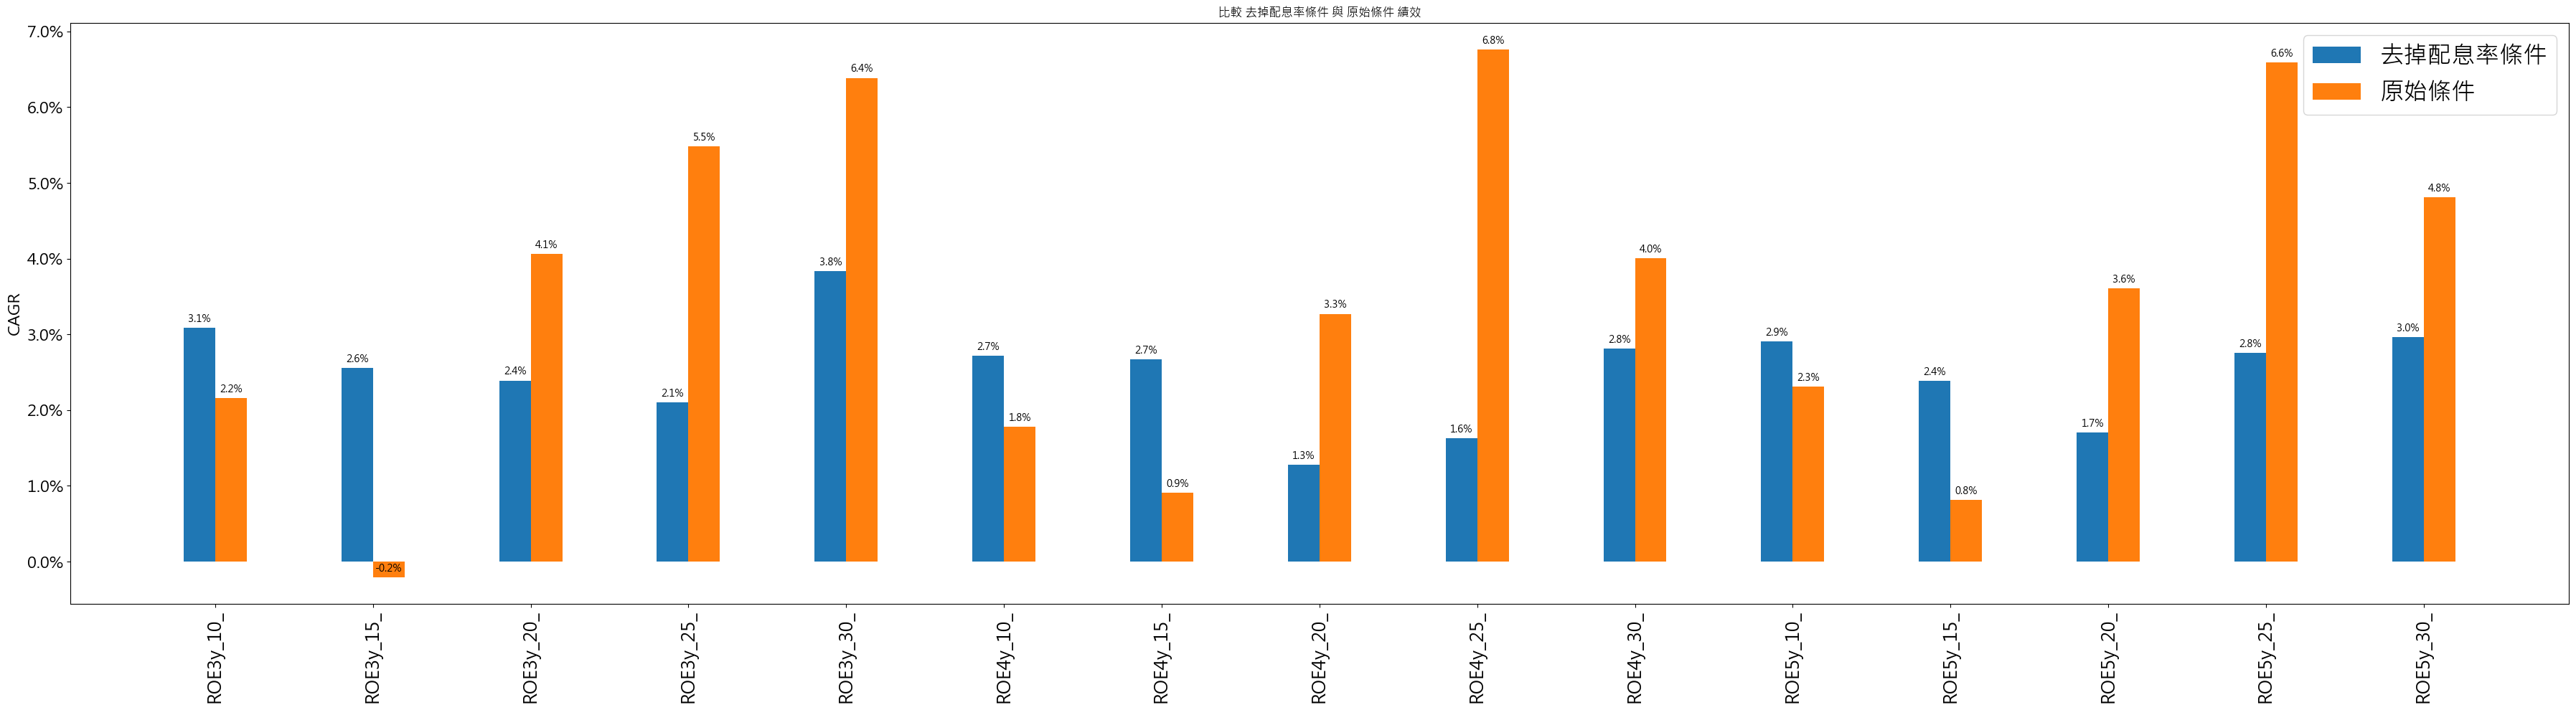

In [65]:
roe_opts_collecs.compare_strat_perform('去掉配息率條件', '原始條件')

## ROE 5年平均 + 配息率調整

In [66]:
payout_roe_opts = {}

conds_without_roe_payout = rr_cond & netprofit_cond & listed_cond #[START_DATE:END_DATE]

for i in range(0, 56, 5):
    # for j in range(10, 13, 2):
    for k in range(10, 46, 5):

        # ROE n年平均 > k%
        df = roe.copy()
        # 提取index的月份
        df['month'] = df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
        # 刪除用來group的欄位
        roe_rol_opt_df = result.drop(columns='month')
        roe_cond_opt = roe_rol_opt_df > (k / 100)

        payout_ratio_cond_opt = payout_ratio_rol >= (i/100)
        # per_entry_opt = (daily_pe.resample('M').last() < 12)

        opt_payout_PER_cond = roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout
        

        payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE]) [filtered_russell_1000_symbol]

        # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

        # payout_roe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

payout_roe_opts_comb = sim_conditions(payout_roe_opts, resample='M', data=data)

Backtesting progress: 100%|██████████| 96/96 [03:30<00:00,  2.20s/condition]


In [67]:
payout_roe_opts_comb.selected_stock_count_analysis() #.to_csv('./performance_file/US/美股2003-2009_績效比較_配息率_ROE_test-241119.csv', encoding='cp950')

,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
配息_45%_ROE_40,19.83,-34.11,1.32,1.0,0.0,2.0,0.0,3.0
配息_45%_ROE_35,17.29,-38.72,2.25,2.0,2.0,3.0,1.0,3.0
配息_50%_ROE_40,14.87,-34.11,0.52,1.0,0.0,1.0,0.0,1.0
配息_20%_ROE_45,14.43,-47.53,3.85,4.0,3.0,5.0,2.0,6.0
配息_0%_ROE_45,14.25,-47.05,5.29,5.0,4.0,6.0,3.0,10.0
...,...,...,...,...,...,...,...,...
配息_35%_ROE_15,3.06,-45.54,21.12,19.0,18.0,23.0,14.0,35.0
配息_5%_ROE_20,2.98,-52.45,40.04,35.0,32.0,47.0,25.0,72.0
配息_40%_ROE_15,2.78,-50.26,14.59,14.0,11.0,15.0,10.0,24.0


In [68]:

# df = payout_roe_opts_comb.selected_stock_count_analysis()

# # Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
# df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extracting 配息率 (N)
# df['X'] = df.index.map(lambda x: x.split('_')[-1])                  # Extracting ROE (X)

# # Converting to numeric types
# df['N'] = pd.to_numeric(df['N'], errors='coerce')
# df['X'] = pd.to_numeric(df['X'], errors='coerce')

# # Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
# heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# # Plotting the heatmap with reversed Y-axis, in coolwarm color scheme, and custom labels
# plt.figure(figsize=(16, 5))
# sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'CAGR (%)'}, 
#             yticklabels=heatmap_data.index[:])
# plt.xlabel("配息率三年至少 (%)")
# plt.ylabel("五年ROE平均 > N %")
# plt.title("【羅素1000】五年平均ROE + 配息率條件 2003~2009")
# plt.show()

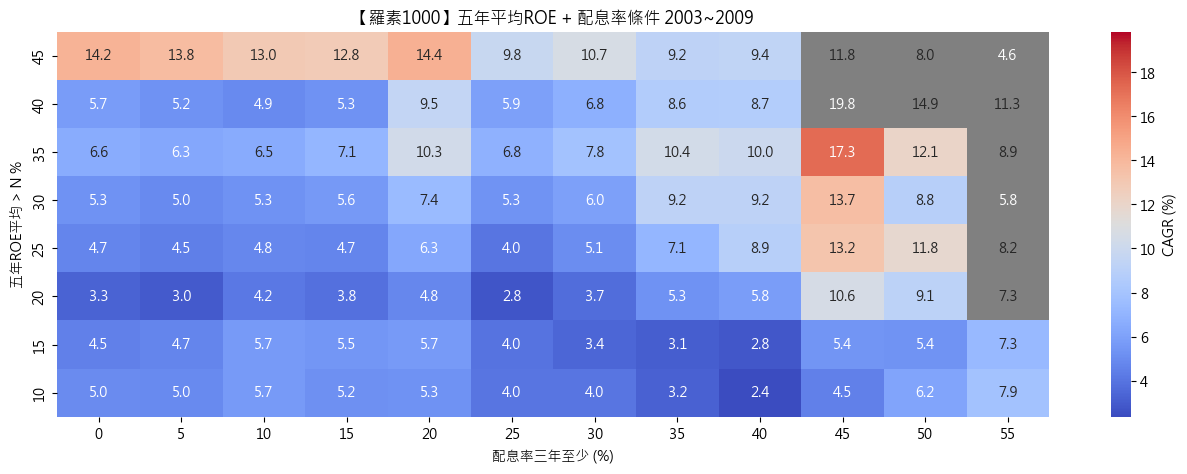

In [69]:
df = payout_roe_opts_comb.selected_stock_count_analysis()

# Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
df['N'] = df.index.map(lambda x: x.split('_')[1].replace('%', ''))  # Extracting 配息率 (N)
df['X'] = df.index.map(lambda x: x.split('_')[-1])                  # Extracting ROE (X)

# Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# Creating a mask for cells where 'Min' equals 0
min_mask_raw = df.pivot(index="X", columns="N", values="Min") == 0

# Align mask with heatmap_data (ensure same index and columns)
min_mask = min_mask_raw.reindex(index=heatmap_data.index, columns=heatmap_data.columns).fillna(False)

# Custom colormap: using "coolwarm" for normal data and "red" for highlighted cells
normal_cmap = sns.color_palette("coolwarm", as_cmap=True)
highlight_cmap = ListedColormap(["gray"])

# Plotting the heatmap
plt.figure(figsize=(16, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=normal_cmap, cbar_kws={'label': 'CAGR (%)'}, 
            yticklabels=heatmap_data.index[:])

# Overlay another heatmap for the highlighted cells
sns.heatmap(heatmap_data, mask=~min_mask, cmap=highlight_cmap, cbar=False, annot=False)

# Adding labels and title
plt.xlabel("配息率三年至少 (%)")
plt.ylabel("五年ROE平均 > N %")
plt.title("【羅素1000】五年平均ROE + 配息率條件 2003~2009")
plt.show()

In [70]:
# payout_roe_opts_comb.reports['配息_10%_ROE_45'].display()

In [71]:
# p, _=payout_roe_opts_comb.reports['配息_0%_ROE_15'].calc_returns_contrib()

In [72]:
# print(p[2008])

---

In [73]:
payout_roe_pe_opts = {}

conds_without_roe_payout = rr_cond & netprofit_cond & listed_cond #[START_DATE:END_DATE]

# for i in range(0, 56, 5):
#     # for j in range(10, 13, 2):
for k in range(10, 46, 5):

    for p in range(8, 19, 2):

        # ROE n年平均 > k%
        df = roe.copy()
        # 提取index的月份
        df['month'] = df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
        # 刪除用來group的欄位
        roe_rol_opt_df = result.drop(columns='month')
        roe_cond_opt = roe_rol_opt_df > (k / 100)

        payout_ratio_cond_opt = payout_ratio_rol >= 0.4

        per_entry_opt = (pe_daily.resample('M').last() < p)

        opt_payout_PER_cond = roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout
        

        payout_roe_pe_opts[f'ROE_{k}_本益比{p}'] = (opt_payout_PER_cond[START_DATE:END_DATE] & per_entry_opt[START_DATE:END_DATE]).hold_until((~opt_payout_PER_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE]) #[filtered_russell_1000_symbol]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

payout_roe_pe_opts_comb = sim_conditions(payout_roe_pe_opts, resample='M', data=data)

Backtesting progress: 100%|██████████| 48/48 [01:56<00:00,  2.43s/condition]


In [74]:
payout_roe_pe_opts_comb.selected_stock_count_analysis()

,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
ROE_40_本益比8,16.32,-38.37,2.01,2.0,1.0,3.0,0.0,5.0
ROE_45_本益比8,11.17,-38.35,1.04,1.0,0.0,2.0,0.0,3.0
ROE_40_本益比14,9.91,-30.08,3.45,3.0,2.0,5.0,1.0,7.0
ROE_45_本益比14,8.80,-28.82,2.26,2.0,1.0,3.0,1.0,5.0
ROE_45_本益比16,8.70,-32.22,2.49,2.0,2.0,3.0,1.0,5.0
ROE_45_本益比18,8.49,-32.22,2.52,2.0,2.0,3.0,1.0,5.0
ROE_40_本益比16,8.29,-32.22,3.79,3.0,2.0,5.0,2.0,8.0
ROE_40_本益比12,7.74,-37.62,3.33,3.0,2.0,5.0,1.0,7.0
ROE_40_本益比18,7.67,-32.22,3.82,3.0,2.0,5.0,2.0,8.0


In [75]:
df_roe_pe = payout_roe_pe_opts_comb.selected_stock_count_analysis()

In [76]:
import re

# 提取 N 和 K
def extract_values(index):
    match = re.match(r"ROE_(\d+)_本益比(\d+)", index)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

# 解析出 ROE (N) 和 本益比 (K)
df_roe_pe['ROE_N'], df_roe_pe['PE_K'] = zip(*df_roe_pe.index.map(extract_values))

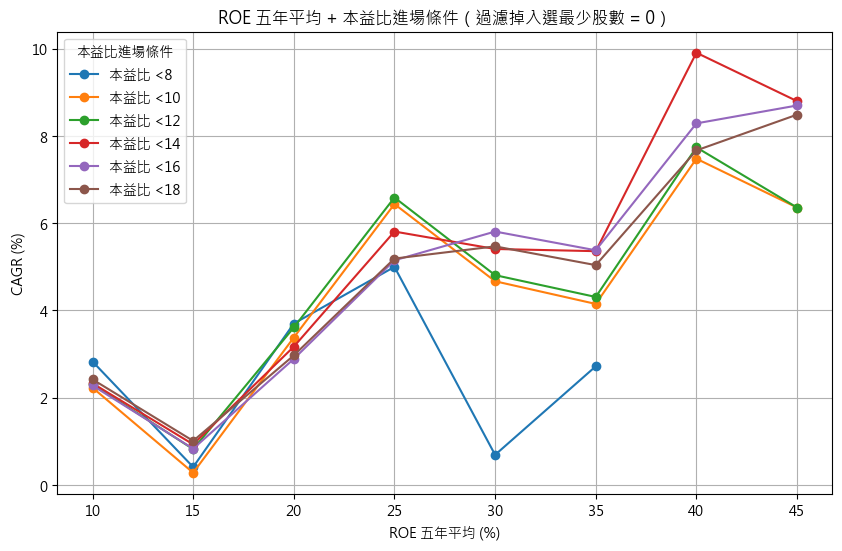

In [77]:
# 過濾掉 Min 為 0 的行
filtered_df = df_roe_pe[df_roe_pe['Min'] != 0]

# 按照本益比分類繪製折線圖
plt.figure(figsize=(10, 6))

for pe_k, group in filtered_df.groupby('PE_K'):
    group_sorted = group.sort_values('ROE_N')
    plt.plot(group_sorted['ROE_N'], group_sorted['CAGR (%)'], marker='o', label=f"本益比 <{pe_k}")

# 繪製圖表
plt.title("ROE 五年平均 + 本益比進場條件（過濾掉入選最少股數 = 0）")
plt.xlabel("ROE 五年平均 (%)")
plt.ylabel("CAGR (%)")
plt.legend(title="本益比進場條件")
plt.grid()
plt.show()

---

In [78]:
rr_pe_opts = {}

conds_without_rr = roe_cond & payout_cond & netprofit_cond & listed_cond #[START_DATE:END_DATE]

# for i in range(0, 56, 5):
#     # for j in range(10, 13, 2):
for k in range(10, 81, 5):

    for p in range(8, 19, 2):

        rr_cond_opt = rr < (k / 100)

        per_entry_opt = (pe_daily.resample('M').last() < p)

        opt_rr_PER_cond = conds_without_rr & rr_cond_opt
        

        rr_pe_opts[f'盈再率_{k}_本益比{p}'] = (opt_rr_PER_cond[START_DATE:END_DATE] & per_entry_opt[START_DATE:END_DATE]).hold_until((~opt_rr_PER_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE]) #[filtered_russell_1000_symbol]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

rr_pe_opts_comb = sim_conditions(rr_pe_opts, resample='M', data=data)
rr_pe_opts_comb.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 90/90 [02:57<00:00,  1.97s/condition]


,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
盈再率_15_本益比8,4.15,-57.07,8.97,8.0,7.0,8.0,5.0,19.0
盈再率_10_本益比8,4.06,-57.90,7.59,6.0,6.0,7.0,4.0,17.0
盈再率_15_本益比18,3.50,-52.68,14.99,14.0,12.0,17.0,10.0,24.0
盈再率_15_本益比16,3.37,-52.68,14.77,14.0,11.0,17.0,9.0,24.0
盈再率_15_本益比14,3.37,-52.52,14.15,13.0,11.0,16.0,9.0,24.0
...,...,...,...,...,...,...,...,...
盈再率_50_本益比10,-0.36,-55.01,14.60,12.0,11.0,17.0,10.0,27.0
盈再率_55_本益比10,-0.36,-55.01,14.62,12.0,11.0,17.0,10.0,27.0
盈再率_80_本益比8,-0.48,-56.31,14.67,14.0,12.0,16.0,12.0,25.0


In [79]:
df_rr_pe = rr_pe_opts_comb.selected_stock_count_analysis()

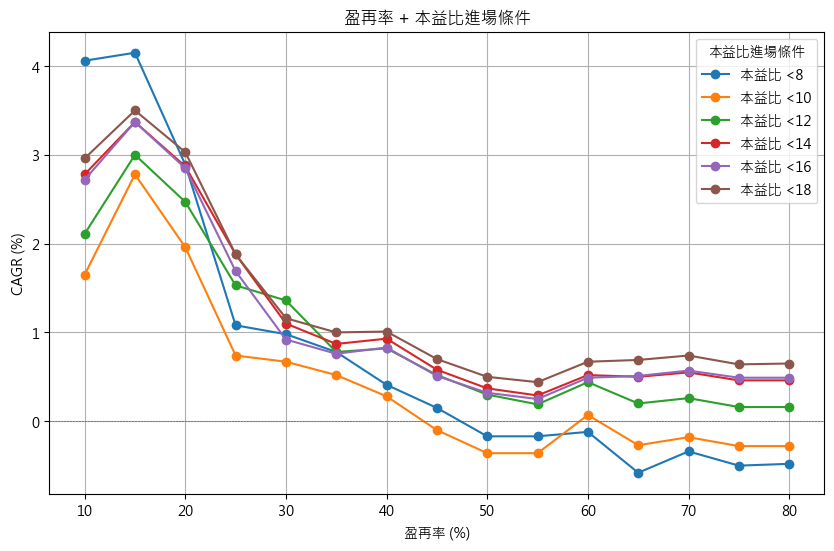

In [80]:
# 提取 N 和 K
def extract_values(index):
    match = re.match(r"盈再率_(\d+)_本益比(\d+)", index)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

# 解析出 ROE (N) 和 本益比 (K)
df_rr_pe['盈再率_N'], df_rr_pe['PE_K'] = zip(*df_rr_pe.index.map(extract_values))

# 過濾掉 Min 為 0 的行
filtered_df = df_rr_pe[df_rr_pe['Min'] != 0]

# 按照本益比分類繪製折線圖
plt.figure(figsize=(10, 6))

for pe_k, group in filtered_df.groupby('PE_K'):
    group_sorted = group.sort_values('盈再率_N')
    plt.plot(group_sorted['盈再率_N'], group_sorted['CAGR (%)'], marker='o', label=f"本益比 <{pe_k}")

# 繪製圖表
plt.axhline(0., color='r', linestyle='--', linewidth=0.4)
plt.title("盈再率 + 本益比進場條件")
plt.xlabel("盈再率 (%)")
plt.ylabel("CAGR (%)")
plt.legend(title="本益比進場條件")
plt.grid()
plt.show()

In [81]:
rr_roe_opts = {}

conds_without_rr_roe = payout_cond & netprofit_cond & listed_cond

# for i in range(0, 56, 5):
#     # for j in range(10, 13, 2):
for k in range(10, 81, 5):

    for n in range(10, 56, 5):

        rr_cond_opt = rr < (k / 100)

        # ROE n年平均 > k%
        df = roe.copy()
        # 提取index的月份
        df['month'] = df.index.month
        # 依據月份分組，對每個月份的每5年計算平均
        result = df.groupby('month', group_keys=False).apply(lambda group: group.rolling(5, min_periods=5).mean())
        # 刪除用來group的欄位
        roe_rol_opt_df = result.drop(columns='month')
        roe_cond_opt = roe_rol_opt_df > (n / 100)

        opt_rr_roe_cond = roe_cond_opt & rr_cond_opt & conds_without_rr_roe
        

        rr_roe_opts[f'盈再率_{k}_ROE_{n}'] = (opt_rr_roe_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~opt_rr_roe_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE]) #[filtered_russell_1000_symbol]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

rr_roe_opts_comb = sim_conditions(rr_roe_opts, resample='M', data=data)
rr_roe_opts_comb.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 150/150 [04:24<00:00,  1.76s/condition]


,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
盈再率_15_ROE_40,20.03,-34.11,2.68,3.0,1.0,4.0,0.0,6.0
盈再率_10_ROE_40,18.97,-34.11,2.33,2.0,1.0,4.0,0.0,5.0
盈再率_15_ROE_45,12.28,-19.38,1.88,2.0,0.0,3.0,0.0,5.0
盈再率_20_ROE_40,12.12,-43.80,3.01,3.0,1.0,4.0,1.0,7.0
盈再率_10_ROE_45,11.44,-19.38,1.68,2.0,0.0,3.0,0.0,4.0
...,...,...,...,...,...,...,...,...
盈再率_70_ROE_15,0.26,-53.14,20.71,20.0,18.0,24.0,15.0,29.0
盈再率_65_ROE_15,0.20,-53.05,19.89,20.0,17.0,22.0,14.0,29.0
盈再率_55_ROE_15,0.19,-53.27,17.97,17.0,14.0,21.0,12.0,29.0


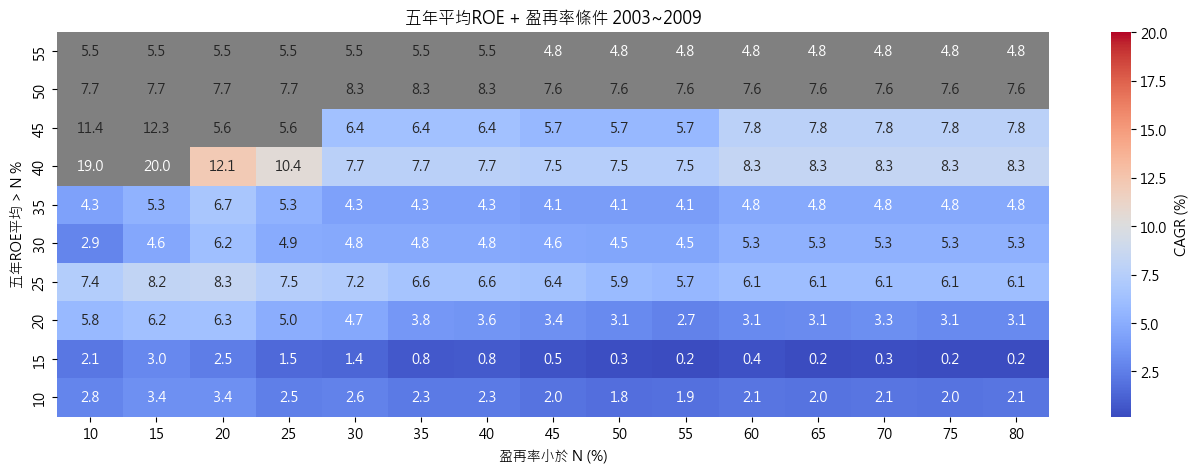

In [82]:
df = rr_roe_opts_comb.selected_stock_count_analysis()

# Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
df['N'] = df.index.map(lambda x: x.split('_')[1])
df['X'] = df.index.map(lambda x: x.split('_')[-1])

# Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# Creating a mask for cells where 'Min' equals 0
min_mask_raw = df.pivot(index="X", columns="N", values="Min") == 0

# Align mask with heatmap_data (ensure same index and columns)
min_mask = min_mask_raw.reindex(index=heatmap_data.index, columns=heatmap_data.columns).fillna(False)

# Custom colormap: using "coolwarm" for normal data and "red" for highlighted cells
normal_cmap = sns.color_palette("coolwarm", as_cmap=True)
highlight_cmap = ListedColormap(["gray"])

# Plotting the heatmap
plt.figure(figsize=(16, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=normal_cmap, cbar_kws={'label': 'CAGR (%)'}, 
            yticklabels=heatmap_data.index[:])

# Overlay another heatmap for the highlighted cells
sns.heatmap(heatmap_data, mask=~min_mask, cmap=highlight_cmap, cbar=False, annot=False)

# Adding labels and title
plt.xlabel("盈再率小於 N (%)")
plt.ylabel("五年ROE平均 > N %")
plt.title("五年平均ROE + 盈再率條件 2003~2009")
plt.show()

In [83]:
rr_dpr_opts = {}

conds_without_rr_dpr = roe_cond & netprofit_cond & listed_cond


for k in range(10, 81, 5):

    for n in range(0, 56, 5):

        rr_cond_opt = rr < (k / 100)

        payout_ratio_cond_opt = payout_ratio_rol >= (n/100)

        opt_rr_dpr_cond = conds_without_rr_dpr & rr_cond_opt & payout_ratio_cond_opt
        

        rr_dpr_opts[f'盈再率_{k}_配息率_{n}'] = (opt_rr_dpr_cond[START_DATE:END_DATE] & daily_pe_entry[START_DATE:END_DATE]).hold_until((~opt_rr_dpr_cond[START_DATE:END_DATE]) | daily_pe_exit[START_DATE:END_DATE]) #[filtered_russell_1000_symbol]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = opt_payout_PER_cond[START_DATE:END_DATE]

        # payout_roe_pe_opts[f'配息_{i}%_ROE_{k}'] = (opt_payout_PER_cond['2009-3':] & daily_pe_entry['2009-3':]).hold_until((~opt_payout_PER_cond['2009-3':]) | daily_pe_exit['2009-3':])

rr_dpr_opts_comb = sim_conditions(rr_dpr_opts, resample='M', data=data)
rr_dpr_opts_comb.selected_stock_count_analysis()

Backtesting progress: 100%|██████████| 180/180 [19:00<00:00,  6.33s/condition]


,CAGR (%),MDD (%),入選股數平均,中位數,25%,75%,Min,Max
Strategy,,,,,,,,
盈再率_20_配息率_45,4.37,-54.10,9.47,9.0,7.0,11.0,5.0,17.0
盈再率_25_配息率_45,4.04,-54.10,9.55,9.0,7.0,11.0,5.0,17.0
盈再率_30_配息率_45,3.93,-54.75,9.92,9.0,7.0,11.0,5.0,19.0
盈再率_15_配息率_45,3.87,-54.89,9.12,8.0,7.0,11.0,5.0,16.0
盈再率_80_配息率_10,3.77,-50.48,80.52,68.0,65.0,92.0,56.0,152.0
...,...,...,...,...,...,...,...,...
盈再率_70_配息率_40,0.26,-53.14,20.71,20.0,18.0,24.0,15.0,29.0
盈再率_65_配息率_40,0.20,-53.05,19.89,20.0,17.0,22.0,14.0,29.0
盈再率_55_配息率_40,0.19,-53.27,17.97,17.0,14.0,21.0,12.0,29.0


c:\Users\user\anaconda3\envs\lab_exp\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning:

All-NaN slice encountered

c:\Users\user\anaconda3\envs\lab_exp\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning:

All-NaN slice encountered



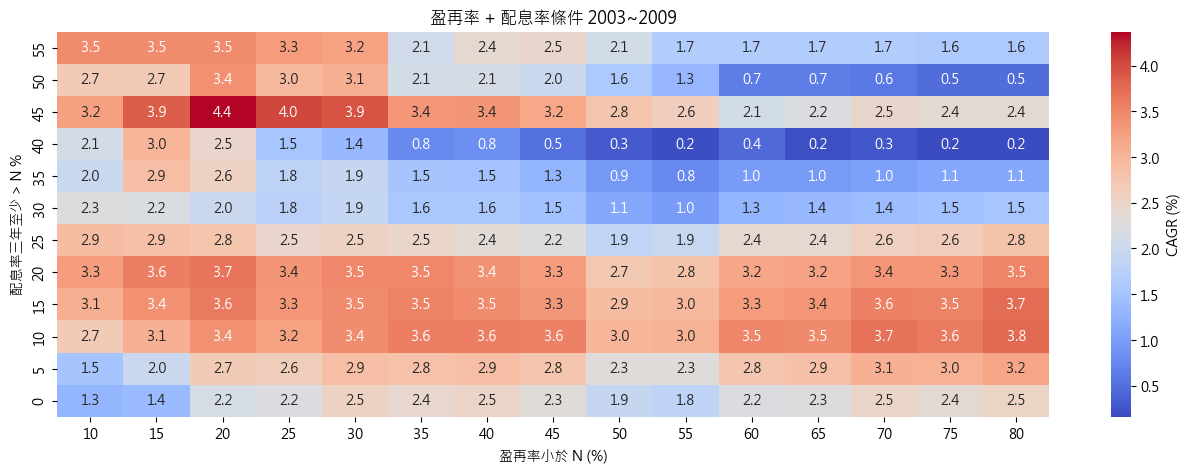

In [84]:
df = rr_dpr_opts_comb.selected_stock_count_analysis()

# Extracting 'N' and 'X' values manually based on the new format "配息_{N}%_ROE_{X}"
df['N'] = df.index.map(lambda x: x.split('_')[1])
df['X'] = df.index.map(lambda x: x.split('_')[-1])

# Converting to numeric types
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['X'] = pd.to_numeric(df['X'], errors='coerce')

# Pivoting data to create a matrix for heatmap with ROE (X) as columns and 配息率 (N) as rows
heatmap_data = df.pivot(index="X", columns="N", values="CAGR (%)").sort_index(ascending=False)

# Creating a mask for cells where 'Min' equals 0
min_mask_raw = df.pivot(index="X", columns="N", values="Min") == 0

# Align mask with heatmap_data (ensure same index and columns)
min_mask = min_mask_raw.reindex(index=heatmap_data.index, columns=heatmap_data.columns).fillna(False)

# Custom colormap: using "coolwarm" for normal data and "red" for highlighted cells
normal_cmap = sns.color_palette("coolwarm", as_cmap=True)
highlight_cmap = ListedColormap(["gray"])

# Plotting the heatmap
plt.figure(figsize=(16, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=normal_cmap, cbar_kws={'label': 'CAGR (%)'}, 
            yticklabels=heatmap_data.index[:])

# Overlay another heatmap for the highlighted cells
sns.heatmap(heatmap_data, mask=~min_mask, cmap=highlight_cmap, cbar=False, annot=False)

# Adding labels and title
plt.xlabel("盈再率小於 N (%)")
plt.ylabel("配息率三年至少 > N %")
plt.title("盈再率 + 配息率條件 2003~2009")
plt.show()

---

---